In [35]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [36]:
# ====== REQUIRED: SET YOUR ASSIGNED SEED HERE ======
SEED = 20240112  # <-- change to your assigned seed

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

In [37]:
# REQUIRED: results folder for saving figures
os.makedirs("results", exist_ok=True)


In [38]:
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]
num_classes = 10


In [39]:
# Version (No Aug)
transform_noaug = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Version (With Aug) - still satisfies requirement but less destructive
transform_aug = transforms.Compose([
    transforms.RandomRotation(7),
    transforms.RandomHorizontalFlip(p=0.1),
    transforms.RandomAffine(0, translate=(0.05, 0.05)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])


In [ ]:
EPOCHS = 10  
BATCH_SIZE = 64  # keep constant to avoid changing multiple hyperparams

# Datasets
train_ds_noaug = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform_noaug)
train_ds_aug   = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform_aug)

# Test should NEVER be augmented
test_ds = datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform_noaug)

# Loaders
train_loader_noaug = DataLoader(train_ds_noaug, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
train_loader_aug   = DataLoader(train_ds_aug,   batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_loader         = DataLoader(test_ds,       batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

len(train_ds_noaug), len(test_ds)


(60000, 10000)

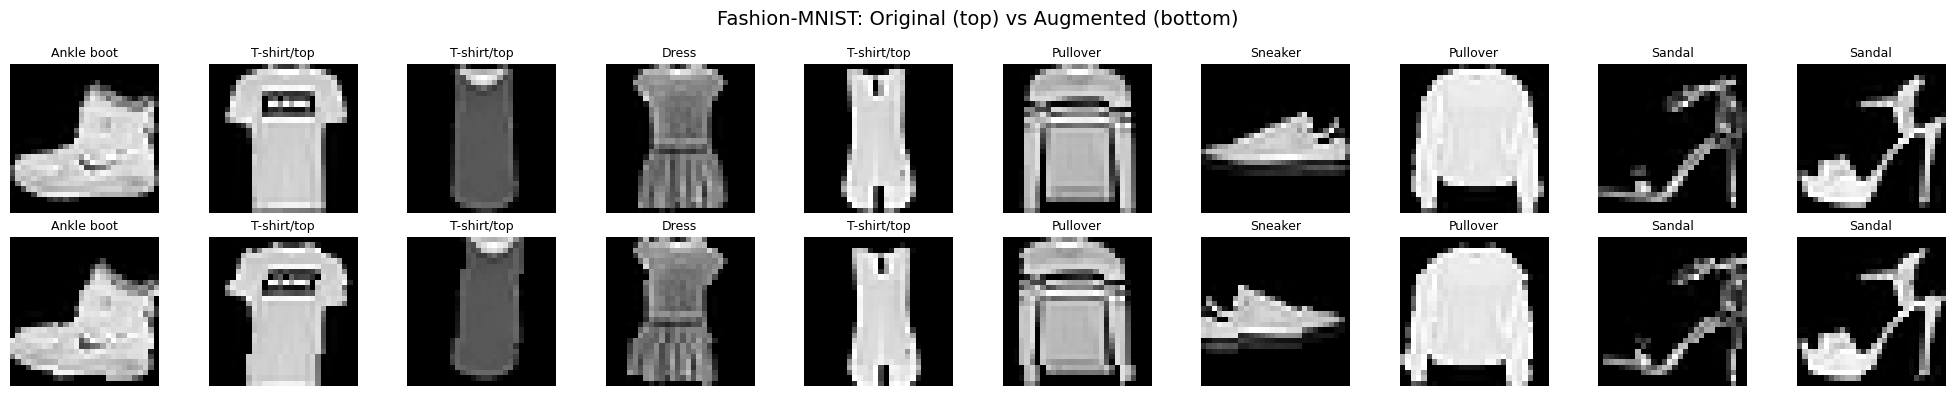

In [41]:
def denormalize(t, mean=(0.1307,), std=(0.3081,)):
    t = t.clone()
    for c in range(t.shape[0]):
        t[c] = t[c] * std[c] + mean[c]
    return t.clamp(0, 1)

def show_original_vs_augmented(ds_plain, ds_aug, n=10, save_path="results/original_vs_augmented.png"):
    fig, axes = plt.subplots(2, n, figsize=(2*n, 4))
    fig.suptitle("Fashion-MNIST: Original (top) vs Augmented (bottom)", fontsize=14)

    for i in range(n):
        img1, y1 = ds_plain[i]
        img2, y2 = ds_aug[i]

        img1_vis = denormalize(img1).squeeze().cpu().numpy()
        img2_vis = denormalize(img2).squeeze().cpu().numpy()

        axes[0, i].imshow(img1_vis, cmap="gray")
        axes[0, i].set_title(class_names[y1], fontsize=9)
        axes[0, i].axis("off")

        axes[1, i].imshow(img2_vis, cmap="gray")
        axes[1, i].set_title(class_names[y2], fontsize=9)
        axes[1, i].axis("off")

    plt.tight_layout()
    plt.savefig(save_path, dpi=200)
    plt.show()

show_original_vs_augmented(train_ds_noaug, train_ds_aug, n=10)


In [44]:
class Task12CNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.classifier(self.features(x))

def count_params(model):
    return sum(p.numel() for p in model.parameters())

tmp = Task12CNN()
count_params(tmp)


421642

In [45]:
def accuracy_from_logits(logits, y):
    preds = torch.argmax(logits, dim=1)
    return (preds == y).float().mean().item()

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss, total_acc, n_batches = 0.0, 0.0, 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_acc  += accuracy_from_logits(logits, y)
        n_batches += 1

    return total_loss / n_batches, total_acc / n_batches

@torch.no_grad()
def eval_model(model, loader, criterion):
    model.eval()
    total_loss, total_acc, n_batches = 0.0, 0.0, 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)

        total_loss += loss.item()
        total_acc  += accuracy_from_logits(logits, y)
        n_batches += 1

    return total_loss / n_batches, total_acc / n_batches

def train_model(run_name, train_loader, test_loader, lr, epochs=10):
    model = Task12CNN(num_classes=10).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    history = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

    for epoch in range(1, epochs + 1):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion)
        te_loss, te_acc = eval_model(model, test_loader, criterion)

        history["train_loss"].append(tr_loss)
        history["train_acc"].append(tr_acc)
        history["test_loss"].append(te_loss)
        history["test_acc"].append(te_acc)

        print(f"{run_name} | Epoch {epoch:02d}/{epochs} | "
              f"Train: loss={tr_loss:.4f}, acc={tr_acc*100:.2f}% | "
              f"Test: loss={te_loss:.4f}, acc={te_acc*100:.2f}%")

    return model, history


In [46]:
LR_LIST = [0.001, 0.0001]  # Option A (two hyperparameter settings)

runs = {}  # store models + histories

for lr in LR_LIST:
    # No augmentation
    name_noaug = f"NoAug_LR={lr}"
    print("\n" + "="*80)
    model, hist = train_model(name_noaug, train_loader_noaug, test_loader, lr=lr, epochs=EPOCHS)
    runs[name_noaug] = {"model": model, "hist": hist, "lr": lr, "aug": False}

    # With augmentation
    name_aug = f"Aug_LR={lr}"
    print("\n" + "="*80)
    model, hist = train_model(name_aug, train_loader_aug, test_loader, lr=lr, epochs=EPOCHS)
    runs[name_aug] = {"model": model, "hist": hist, "lr": lr, "aug": True}


/Users/oguzisayev/Nargiz Abiyeva AI/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


NoAug_LR=0.001 | Epoch 01/10 | Train: loss=0.5254, acc=81.01% | Test: loss=0.3465, acc=87.09%
NoAug_LR=0.001 | Epoch 02/10 | Train: loss=0.3511, acc=87.53% | Test: loss=0.2938, acc=89.11%
NoAug_LR=0.001 | Epoch 03/10 | Train: loss=0.2992, acc=89.44% | Test: loss=0.2651, acc=90.36%
NoAug_LR=0.001 | Epoch 04/10 | Train: loss=0.2690, acc=90.29% | Test: loss=0.2613, acc=90.87%
NoAug_LR=0.001 | Epoch 05/10 | Train: loss=0.2451, acc=91.12% | Test: loss=0.2508, acc=91.27%
NoAug_LR=0.001 | Epoch 06/10 | Train: loss=0.2291, acc=91.61% | Test: loss=0.2325, acc=91.59%
NoAug_LR=0.001 | Epoch 07/10 | Train: loss=0.2162, acc=92.11% | Test: loss=0.2458, acc=91.09%
NoAug_LR=0.001 | Epoch 08/10 | Train: loss=0.2028, acc=92.60% | Test: loss=0.2335, acc=92.02%
NoAug_LR=0.001 | Epoch 09/10 | Train: loss=0.1856, acc=93.02% | Test: loss=0.2404, acc=91.93%
NoAug_LR=0.001 | Epoch 10/10 | Train: loss=0.1766, acc=93.31% | Test: loss=0.2405, acc=91.86%

Aug_LR=0.001 | Epoch 01/10 | Train: loss=0.6074, acc=77.53%

In [47]:
print("\n=== FINAL TEST ACCURACIES ===")
for k, v in runs.items():
    final_acc = v["hist"]["test_acc"][-1] * 100
    print(f"{k:15s} | final test acc: {final_acc:.2f}%")



=== FINAL TEST ACCURACIES ===
NoAug_LR=0.001  | final test acc: 91.86%
Aug_LR=0.001    | final test acc: 90.98%
NoAug_LR=0.0001 | final test acc: 89.56%
Aug_LR=0.0001   | final test acc: 88.98%


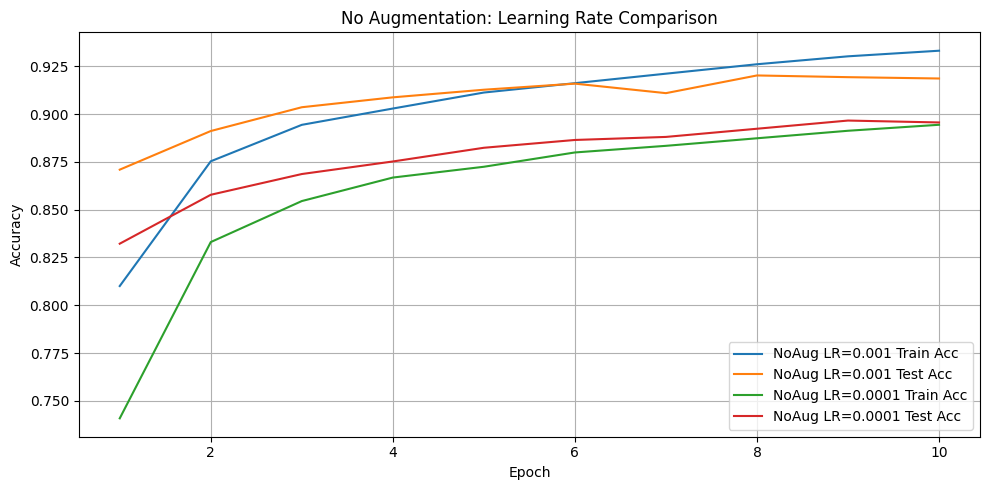

In [48]:
def plot_two_histories(hist_a, label_a, hist_b, label_b, title, save_path):
    epochs = np.arange(1, len(hist_a["test_acc"]) + 1)

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, hist_a["train_acc"], label=f"{label_a} Train Acc")
    plt.plot(epochs, hist_a["test_acc"],  label=f"{label_a} Test Acc")
    plt.plot(epochs, hist_b["train_acc"], label=f"{label_b} Train Acc")
    plt.plot(epochs, hist_b["test_acc"],  label=f"{label_b} Test Acc")

    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(save_path, dpi=200)
    plt.show()

hist_noaug_1 = runs["NoAug_LR=0.001"]["hist"]
hist_noaug_2 = runs["NoAug_LR=0.0001"]["hist"]

plot_two_histories(
    hist_noaug_1, "NoAug LR=0.001",
    hist_noaug_2, "NoAug LR=0.0001",
    title="No Augmentation: Learning Rate Comparison",
    save_path="results/training_comparison_noaug_lr.png"
)


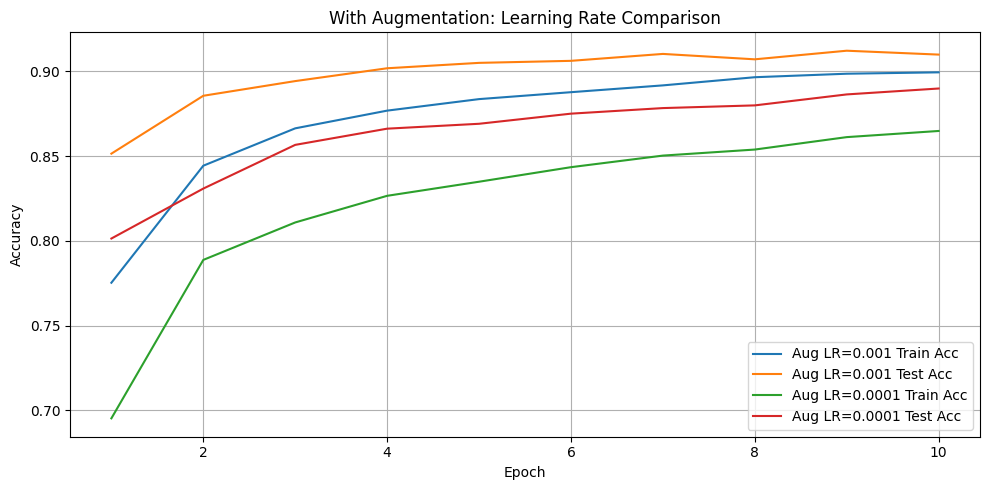

In [49]:
hist_aug_1 = runs["Aug_LR=0.001"]["hist"]
hist_aug_2 = runs["Aug_LR=0.0001"]["hist"]

plot_two_histories(
    hist_aug_1, "Aug LR=0.001",
    hist_aug_2, "Aug LR=0.0001",
    title="With Augmentation: Learning Rate Comparison",
    save_path="results/training_comparison_aug_lr.png"
)


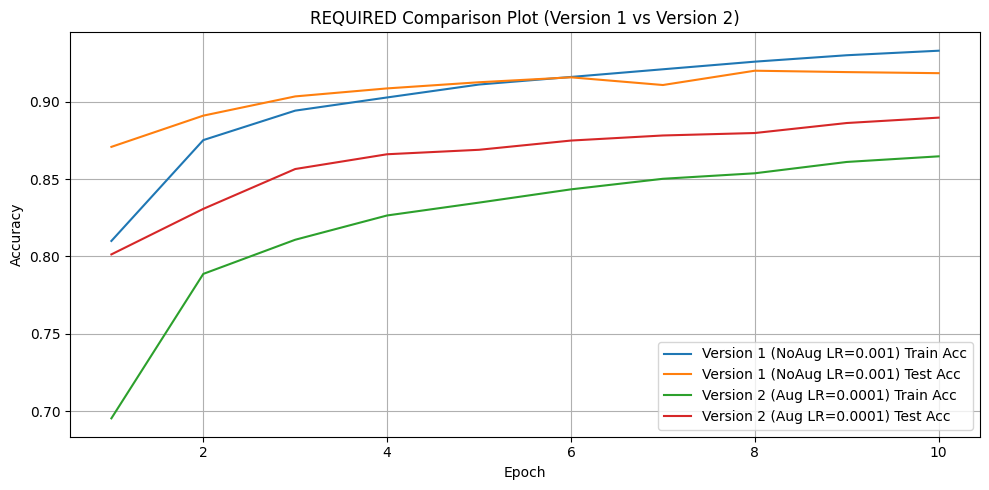

In [50]:
plot_two_histories(
    runs["NoAug_LR=0.001"]["hist"], "Version 1 (NoAug LR=0.001)",
    runs["Aug_LR=0.0001"]["hist"],  "Version 2 (Aug LR=0.0001)",
    title="REQUIRED Comparison Plot (Version 1 vs Version 2)",
    save_path="results/training_comparison.png"
)


In [52]:
best_key = None
best_acc = -1.0

for k, v in runs.items():
    acc = v["hist"]["test_acc"][-1] * 100
    if acc > best_acc:
        best_acc = acc
        best_key = k

best_model = runs[best_key]["model"]
print(f"Best run: {best_key} with final test acc = {best_acc:.2f}%")


Best run: NoAug_LR=0.001 with final test acc = 91.86%


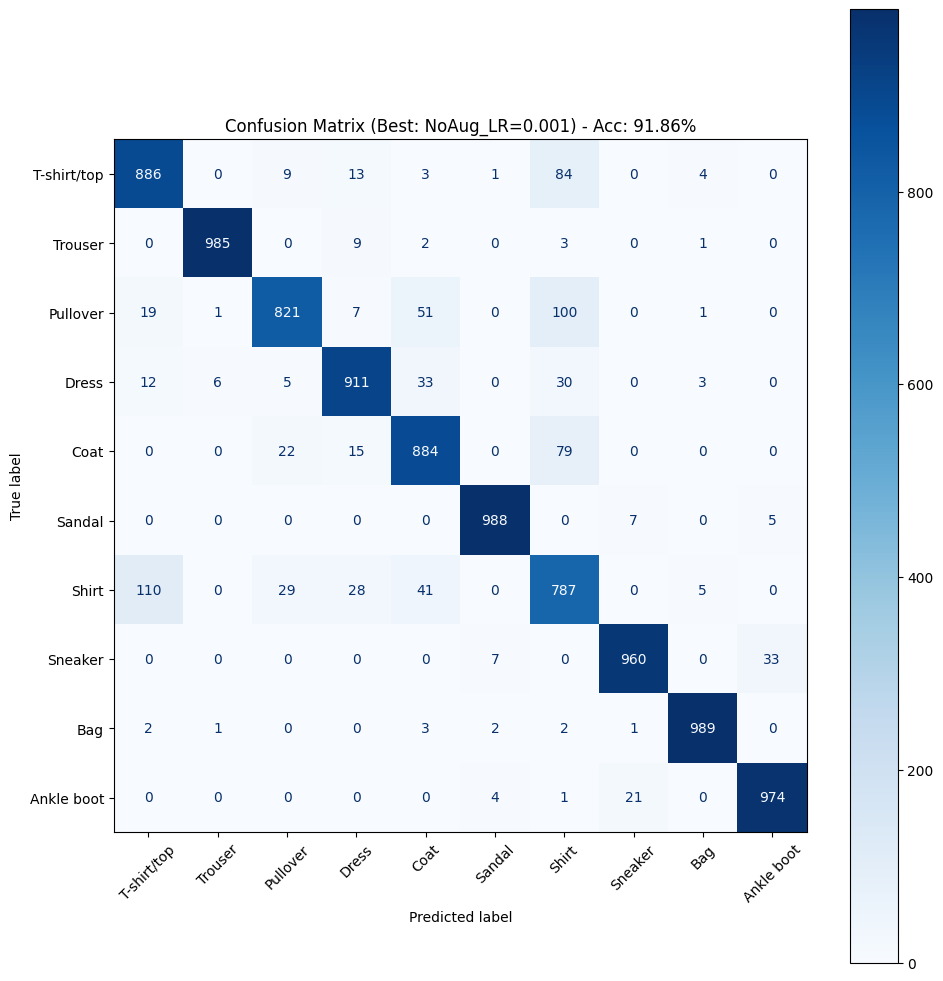

In [53]:
@torch.no_grad()
def get_all_predictions(model, loader):
    model.eval()
    all_preds, all_true = [], []
    for x, y in loader:
        x = x.to(device)
        logits = model(x)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.append(preds)
        all_true.append(y.numpy())
    return np.concatenate(all_true), np.concatenate(all_preds)

y_true, y_pred = get_all_predictions(best_model, test_loader)

cm = confusion_matrix(y_true, y_pred, labels=list(range(10)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, cmap="Blues", colorbar=True, xticks_rotation=45)
plt.title(f"Confusion Matrix (Best: {best_key}) - Acc: {best_acc:.2f}%")
plt.tight_layout()
plt.savefig("results/confusion_matrix.png", dpi=200)
plt.show()


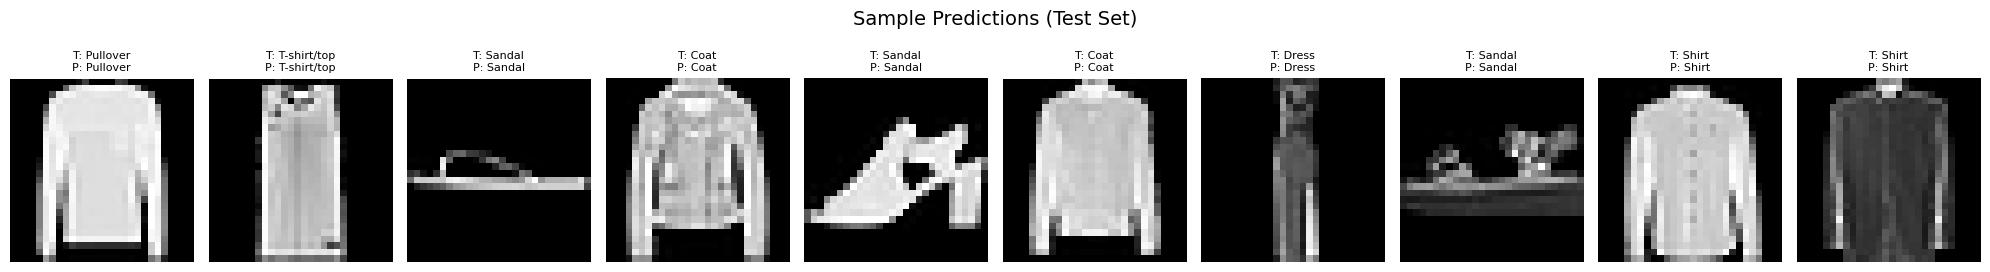

In [54]:
@torch.no_grad()
def plot_sample_predictions(model, dataset, n=10, save_path="results/predictions.png"):
    model.eval()
    indices = np.random.choice(len(dataset), size=n, replace=False)

    fig, axes = plt.subplots(1, n, figsize=(2*n, 3))
    fig.suptitle("Sample Predictions (Test Set)", fontsize=14)

    for i, idx in enumerate(indices):
        img, true_label = dataset[idx]
        x = img.unsqueeze(0).to(device)
        logits = model(x)
        pred = torch.argmax(logits, dim=1).item()

        img_vis = denormalize(img).squeeze().cpu().numpy()
        axes[i].imshow(img_vis, cmap="gray")
        axes[i].set_title(f"T: {class_names[true_label]}\nP: {class_names[pred]}", fontsize=8)
        axes[i].axis("off")

    plt.tight_layout()
    plt.savefig(save_path, dpi=200)
    plt.show()

plot_sample_predictions(best_model, test_ds, n=10)


In [55]:
per_class_acc = []
for c in range(10):
    mask = (y_true == c)
    acc_c = (y_pred[mask] == y_true[mask]).mean() if mask.sum() > 0 else 0.0
    per_class_acc.append(acc_c)

best_class_idx = int(np.argmax(per_class_acc))
worst_class_idx = int(np.argmin(per_class_acc))

print("=== Per-class accuracy ===")
for i, a in enumerate(per_class_acc):
    print(f"{i:02d} {class_names[i]:12s}: {a*100:.2f}%")

print(f"\nBest performing class:  {class_names[best_class_idx]} ({per_class_acc[best_class_idx]*100:.2f}%)")
print(f"Worst performing class: {class_names[worst_class_idx]} ({per_class_acc[worst_class_idx]*100:.2f}%)")


=== Per-class accuracy ===
00 T-shirt/top : 88.60%
01 Trouser     : 98.50%
02 Pullover    : 82.10%
03 Dress       : 91.10%
04 Coat        : 88.40%
05 Sandal      : 98.80%
06 Shirt       : 78.70%
07 Sneaker     : 96.00%
08 Bag         : 98.90%
09 Ankle boot  : 97.40%

Best performing class:  Bag (98.90%)
Worst performing class: Shirt (78.70%)


In [56]:
reqs = """torch
torchvision
numpy
matplotlib
scikit-learn
"""
with open("requirements.txt", "w") as f:
    f.write(reqs)

print("Saved requirements.txt")


Saved requirements.txt
